## Homework 02
#### [An attempt to solution](https://github.com/emaballarin/statistical-machine-learning/blob/master/homeworks/homework_02_solutions.ipynb) by [Emanuele Ballarin](mailto:emanuele@ballarin.cc)

### Exercise 1

One half percent of the population has *coronavirus* and a test is being developed. This test gives a false positive $3\%$ of the time and a false negative $2\%$ of the time. 

1. Find the probability that Luca is positive to the test.
2. Suppose Luca is positive to the test. What is the probability that he has contracted the disease?

#### Solution:

For the sake of clarity in the analysis that follows, it is important to state some hypotheses, preliminarly:

-   *Luca* is assumed to be part of *the population* mentioned, and, furthermore, it is assumed that he has been chosen among it in such way that guarantees he is a *representative sample* of such *population*. This is equivalent to hypothesize that Luca is a randomly-picked member of the population.
-   The same – *mutatis mutandis* – is assumed to hold also for *the eventual test* administered to Luca. This is equivalent to state that – whichever specific test *kit* is utilized to perform the test on Luca – it is hypothesized that such *kit* is randomly-picked among all those available (in the case *FPR* and *FNR* depend on built-in characteristics) or that the test behaves equivalently to that regard (otherwise).

Such hypotheses allow to conclude that:

-   The probability *Luca* has *coronavirus* is the fraction of total population, which *Luca* belongs to, that has *coronavirus*.
-   The probability that a *positive* result of the test is *false* – or that a *negative* result of the test is *false* – is the test *FPR* – or *FNR*, respectively.

This, in addition to the *definition-derived* facts that:

-   Every person either *has* or *has not* *coronavirus*;
-   A test for *coronavirus* either has *positive* or *negative* outcome;
-   A *non-false* positive (or negative) is a *true* positive (or negative);

allows us to formalize the problem as follows.

**As far as a person is concerned:**

-   $x = x_{virus} \in \{0,1\}$ is the binary r.v. modelling the fact that such person has *coronavirus*.
    Specifically: $x_{virus} = 1$ if the person has *coronavirus*; $x_{virus} = 0$ if they have not.
-   $p_{virus} = P(x_{virus} = 1) = 0.5\% = \frac{0.5}{100} = \frac{1}{200} = 0.005$
-   Consequently: $p_{healthy} = P(x_{virus} = 0) = 1-p_{virus} = 0.995$

**As far as the test is concerned:**

-   $FPR = 0.03$
-   $FNR = 0.02$

Meaning that, if:

-   $y = y_{positive} \in \{0,1\}$ is the binary r.v. modelling the fact that a test for *coronavirus* is *positive*.
    Specifically: $y_{positive} = 1$ if the test is positive; .$y_{positive} = 0$ if the test is negative.
-   $p_{positive} = P(y_{positive} = 1)$
-   $p_{negative} = P(y_{positive} = 0) = 1- p_{positive}$

then, assuming $x$ refers to a person and $y$ to the test given to such person:

-   $P( y_{positive} = 1\ |\ x_{virus} = 0) = FPR = 0.03$
-   $P(y_{positive} = 0\ |\ x_{virus} = 1) = FNR = 0.02$.

Consequently:

-   $P(y_{positive} = 1\ |\ x_{virus} = 1) = TPR = 1-FPR = 0.97$
-   $P(y_{positive} = 0\ |\ x_{virus} = 0) = TNR = 1-FNR = 0.98$

***Answer to q. 1:***

If Luca is positive to the test, it is so because either:

-   Luca has coronavirus, and the result of the test is (a true) positive: $P(x=1, y=1)$
-   Luca has not coronavirus, and the result is (a false) positive: $P(x=0, y=1)$

We can now use the definition of conditional probability mass function, i.e. $P(y|x) = \frac{p(x,y)}{p(x)}$, from which we obtain $P(x,y) = p(x)\ p(y|x)$. And we can sum over all possible values of $x$ in the parameter space.

That means $P(y=1) = P(x=1, y=1) + P(x=0, y=1) = p_{virus}\cdot TPR \ +\ p_{healthy}\cdot FPR \\= 0.005 \times 0.97 + 0.995 \times 0.03 = 0.0347$

***Answer to q. 2:***

Knowing that Luca is positive to the test, we can compute the required probability via the *Bayes’ Theorem* result:

$P(x=1 \ |\ y=1) = \frac{P(y=1\ |\ x = 1) \ P(x=1)}{P(y=1)} = \frac{0.97 \times 0.005}{0.0347} = 0.140$.

### Exercise 2

Implement the empirical cumulative distribution function $F_X(x)=$ `cdf(dist, x)` taking as inputs a `pyro.distributions` object `dist`, corresponding to the distribution of $X$, and a real value `x`.

Suppose that $X\sim \mathcal{N}(0,1)$ and plot $F_X(x)$.

#### Solution

**Preliminary note about code efficiency, code duplication and CDF monotonicity:**  
In the algorithmic choices required to tackle a relatively simple problem such as empirical CDF computation, a main issue may arise.
Notwithstanding the fact we are explicitly computing an *empirical CDF*, we know from basic maths that the *true CDF* must be at least weakly monotonic. Such property may be not guaranteed in the *sampling-based* computation of an *eCDF* in the case its point-values are determined via binary splitting (and subsequent counting) of the support of the PDF. It may happen, in fact, that for *sufficiently close* points – regardless of the high sample size – the number of samples occurring at the left of the split-point and at its right may decrease even if the split point shifts right in the support of the PDF.
Such problem my be tackled via *cache-based* solutions (*LRU* mainly), which amortize the efficiency penalty required by a full-support binning and eCDF computation and enforce monotonicity of the eCDF. The price is the lack of true randomness in subsequent function calls (except when requested, at the cost of performance).
Another solution – which will be employed here – consists in the duplication of code and function(s) for the two purposes of computing accurate and efficient point-values of the eCDF and computing its full histogram.
In case of need, the full histogram may also be used when close point-value evaluations of the (same) eCDF must be performed.

In [1]:
# IMPORTS (once and for all!)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as th
import pyro
from pyro import distributions


# Be reproducible
pyro.set_rng_seed(6544)

In [2]:
def cdf(dist, x, samplesize=10000):
    return float(np.count_nonzero(dist([samplesize]).numpy() <= x)) / samplesize


def plot_histcdf(dist, samplesize=10000, unif_bins=250):
    normcounts, edges = np.histogram(dist([samplesize]), unif_bins, density=False)
    plt.plot(edges[1:], np.cumsum(normcounts) / np.sum(normcounts))
    plt.show()

0.5051


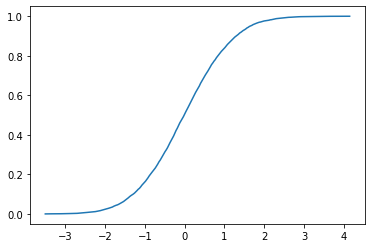

In [3]:
# A test for cdf()
foo = distributions.Uniform(0.0, 10.0)
print(cdf(foo, 5.0))

# The answer to what has been asked
bar = distributions.Normal(0.0, 1.0)
plot_histcdf(bar)

### Exercise 3

Suppose the heights of male students are normally distributed with mean $180$ and unknown variance $\sigma^2$. Suppose that $\sigma^2$ is in the range $[22,41]$ with approximately $95\%$ probability and assign to $\sigma^2$ an inverse-gamma $IG(38,1110)$ prior distribution .

1. Empirically verify that the parameters of the inverse-gamma distribution lead to a prior probability of approximately $95\%$ that  $\sigma^2\in[22,41]$.
2. Derive the posterior density of $\sigma^2$ corresponding to the following data: $183, 173, 181, 170, 176, 180, 187, 176, 171, 190, 184, 173, 176, 179, 181, 186$.
    Then plot it together with the prior density.
3. Compute the posterior density of the standard deviation $\sigma$.

#### Solution:

**Preliminary note about methodology:**  
Given the *high empiricism* required by the exercise, we assume in the following development a *computational-first* approach. This does not mean we will disregard the validity and the feasibility of analytically-obtained results (which we will in fact use); we will simply refer to them without a full proof of derivation. All analytical results referred to may be looked up in the (*great, by-the-way, and sadly*) still not published [chapter nr. 12 *“Bayesian Inference”* of *“Statistical Machine Learning”* – Liu & Wasserman, 2014](http://www.stat.cmu.edu/~larry/=sml/Bayes.pdf).
In any case, such results that will be used afterwards, account for a *likelihood computation* and some *algebric manipulations*. Solution to **Exercise 4** contains a more detailed, *prototypical* analysis of *prior-conjugacy* derivation in a specific case.

In [4]:
# Answer to q. 1
my_invgamma = distributions.InverseGamma(38.0, 1110.0)

numsamples = 10000

samples = my_invgamma([numsamples]).numpy()
print(np.count_nonzero(np.logical_and(samples >= 22.0, samples < 41.0)) / numsamples) # We expect ~ 0.95

0.9464


**Answer to q. 2**  

We use in what follows three relevant results from literature, i.e.:

-   The fact that the *Inverse Gamma distribution* $InvGamma_{\alpha, \beta}(x)$ is a *conjugate prior* distribution w.r.t. the likelihood function for the variance of a Gaussian-distributed sample, known the mean of the generating distribution.
-   The fact that *unbiased sample variance* is the *MLE-obtained* best estimator for the variance of a Gaussian distribution.
-   The fact that the posterior of an *InvGamma-prior/known-mean-Gaussian-variance-likelihood* for a sample with $n$ elements is again an *InvGamma*, with parameters: $InvGamma_{\alpha', \beta'}$ such that $\alpha' = \alpha + \frac{n}{2}; \ \beta' = \beta + \frac{n}{2} \frac{1}{n} \sum_{i=1}^n{(x_i - \mu)^2} = \beta + \frac{1}{2} \sum_{i=1}^n{(x_i - \mu)^2}$, being $\mu$ the known true mean of the Gaussian distribution and $x_i$ the value of each sample scalar.  

We can now solve the exercise computationally.

In [5]:
my_mean = 180.0
prioalpha = 38.0
priobeta = 1110.0

my_sample = np.array(
    [
        183.0,
        173.0,
        181.0,
        170.0,
        176.0,
        180.0,
        187.0,
        176.0,
        171.0,
        190.0,
        184.0,
        173.0,
        176.0,
        179.0,
        181.0,
        186.0,
    ]
)

my_samplesize = np.size(my_sample)

newalpha = prioalpha + (my_samplesize / 2.0)

msdev = np.sum((my_sample - my_mean) ** 2) / my_samplesize
newbeta = priobeta + (my_samplesize / 2.0) * msdev

print(newalpha, newbeta)

46.0 1380.0


Our posterior distribution is:  
$InvGamma_{\alpha', \beta'}$ such that $\alpha' = 46; \ \beta' = 1380$

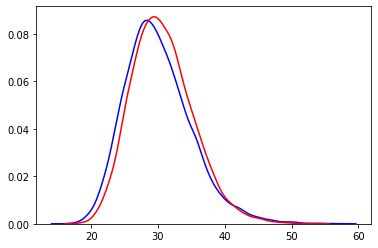

In [6]:
# Plots (obtained via sampling; just wanted to use ProbProg also for that...)

my_invgamma = distributions.InverseGamma(prioalpha, priobeta)
posterior = distributions.InverseGamma(newalpha, newbeta)

sns.distplot(my_invgamma([10000]).numpy(), hist=False, rug=False, color="blue")
sns.distplot(posterior([10000]).numpy(), hist=False, rug=False, color="red")

plt.show()

# Blue plot: Prior
# Red plot: Posterior

# NOTE: These plots, in exact form, could have been obtained throught the SciPy statistical functions and a "canonical" graph plot.

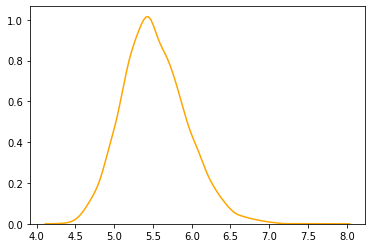

In [7]:
# We can computationally generate and plot the (approximate) distribution p.d.f. of the posterior standard deviation via simulation, exploiting (finally!) a bit the potentialities of ProbProg.
# Full steam ahead! :)

accum = np.sqrt(posterior([10000]).numpy())  # Empirical, computationally-obtained PDF (ePDF), approximate
sns.distplot(accum, hist=False, rug=False, color="orange")
plt.show()

### Exercise 4

Prove that the Gamma distribution is the conjugate prior distribution for the Exponential likelihood.

#### Solution:

In the framework of *Bayesian statistics*, we say that a probability density function – belonging to a particular family – $P(\boldsymbol{\theta})$ is the *conjugate prior distribution* for a given likelihood function $P(\boldsymbol{x}\ |\ \boldsymbol{\theta})$, if the so-computed (i.e. according to *Bayes’ rule*) posterior density function $P(\boldsymbol{\theta}\ |\ \boldsymbol{x})$ belongs to the same family as the prior $P(\boldsymbol{\theta})$.

We consider the 1-dimensional case.

In our scenario, it is given that that:

-   $P(x\ |\ \theta)$ is *exponential*, i.e. $P(x\ |\ \theta) = \begin{cases} \theta \ e^{-{\theta} x} & \text{for } x \geq 0\\0 & \text{for } x < 0 \end{cases}$
-   $P({\theta})$ is a *Gamma distribution*, i.e. $P_{\alpha, \beta}({\theta}) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \ {\theta}^{\alpha - 1} \ e^{-{\beta}{\theta}}$, where $\Gamma(\alpha)$ is Euler’s *Gamma function* computed in $\alpha$.

We need to show that, after the application of *Bayes’ rule* to such distributions – for a set of sampled *i.i.d.* data points determining the *Bayesian update* –, also obtained $P({\theta}\ |\ \boldsymbol{x})$ is in the form of a *Gamma distribution*.

We will call $\boldsymbol{x} = x_1, \dots, x_n$ the data vector comprised of $n$ *i.i.d.* scalars whose (marginal) distribution has *exponential likelihood* given $\theta$.

Since the term at the denominator $P(\boldsymbol{x})$ – the so-called *marginal likelihood* – is fixed for such data, we can ignore it in the following, provided proper normalization is guaranteed.

Since, from *Bayes’ rule*,

$P({\theta}\ |\ \boldsymbol{x}) \propto P(\boldsymbol{x} \ |\ \theta) \ P({\theta})$

in our case:

$P({\theta}\ |\ \boldsymbol{x}) \propto \prod_{i = 1}^n{\theta \ e^{-{\theta} x_i}} \ \frac{\beta^{\alpha}}{\Gamma(\alpha)} \ {\theta}^{\alpha - 1} \ e^{-{\beta}{\theta}}$,

where $\prod_{i = 1}^n{\theta \ e^{-{\theta} x_i}}$ is in fact the computed joint likelihood for our sample.

Thus:

$P(\theta\ |\ \boldsymbol{x}) \propto \prod_{i = 1}^n{\theta \ e^{-{\theta} x_i}} \ \frac{\beta^{\alpha}}{\Gamma(\alpha)} \ {\theta}^{\alpha - 1} \ e^{-{\beta}{\theta}} \\\propto{\theta^n \ e^{-{\theta} \sum_{i = 1}^n x_i}} \ \frac{\beta^{\alpha}}{\Gamma(\alpha)} \ {\theta}^{\alpha - 1} \ e^{-{\beta}{\theta}} \\\propto{\theta}^{\alpha + n -1} \ e^{-{\beta}{\ \theta}{\ \sum_{i = 1}^n x_i}}$,

It follows that $P({\theta}\ |\ \boldsymbol{x}) \propto Gamma(\alpha + n,\ \beta \sum_{i = 1}^n x_i)$, guaranteed proper normalization.